## Feature Engineering
### This notebook summarises the tools and concepts taught at: https://www.kaggle.com/learn/feature-engineering

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

df = pd.read_csv("data_feature/concrete.csv")
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Establishing baseline score

In [2]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Train and score baseline model
baseline = RandomForestRegressor(criterion="absolute_error", random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="neg_mean_absolute_error"
)
baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.232


## Ratio features
Making new features by taking a mixture of different ratios of old features

In [3]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Create synthetic features
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion="absolute_error", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")

MAE Score with Ratio Features: 7.948


## Method 1: Mutual Information
A great first step is to construct a ranking with a feature utility metric, a function measuring associations between a feature and the target. Then you can choose a smaller set of the most useful features to develop initially and have more confidence that your time will be well spent.

The metric we'll use is called **"mutual information"**. Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.

Mutual information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet. It is:

- easy to use and interpret,
- computationally efficient,
- theoretically well-founded,
- resistant to overfitting, and,
- able to detect any kind of relationship

## Mutual Information and What it Measures
Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

## Interpreting Mutual Information Scores
When MI is 0, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

# Set Matplotlib defaults
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


# Load data
df = pd.read_csv("data_feature/ames.csv")


# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

Looking at a few features:

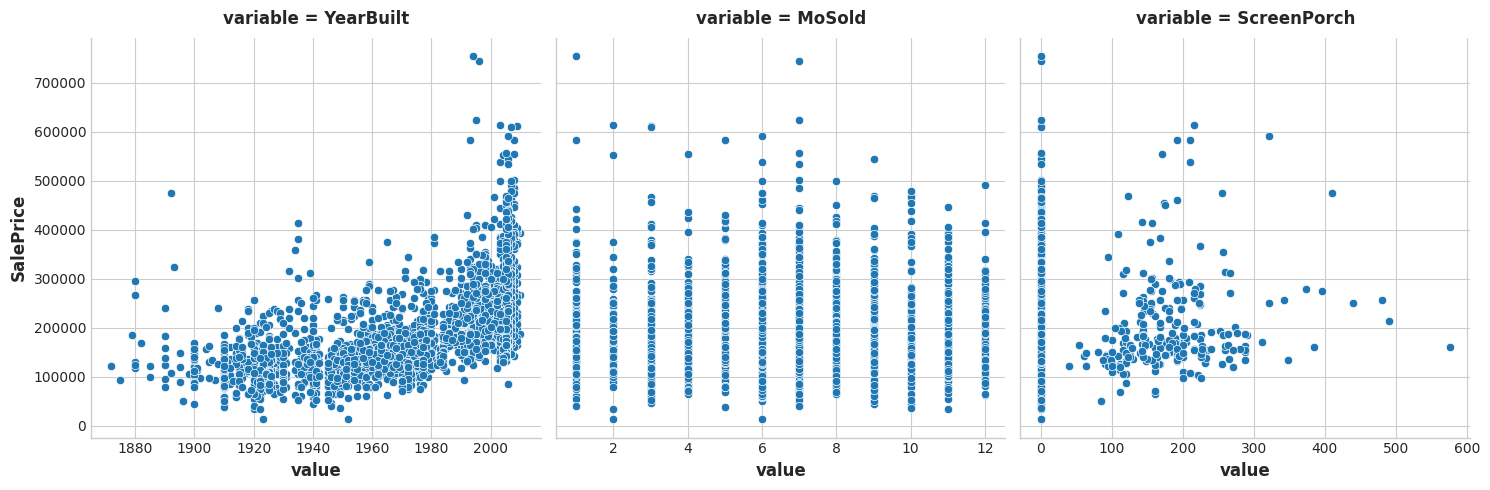

In [7]:
features = ["YearBuilt", "MoSold", "ScreenPorch"]
sns.relplot(
    x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
);

## Calculating MI scores

In [8]:
X = df.copy()
y = X.pop('SalePrice')

mi_scores = make_mi_scores(X, y)

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
ExterQual       0.322390
YearRemodAdd    0.315402
MSSubClass      0.287131
GarageFinish    0.265440
FullBath        0.251693
Foundation      0.236115
LotFrontage     0.233334
GarageType      0.226117
FireplaceQu     0.221955
SecondFlrSF     0.200658
Name: MI Scores, dtype: float64


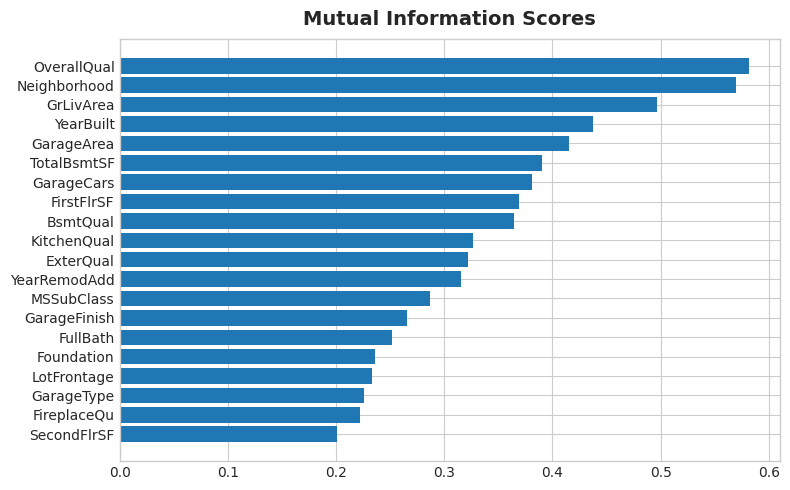

In [9]:
print(mi_scores.head(20))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

## Investigating Building Type Feature

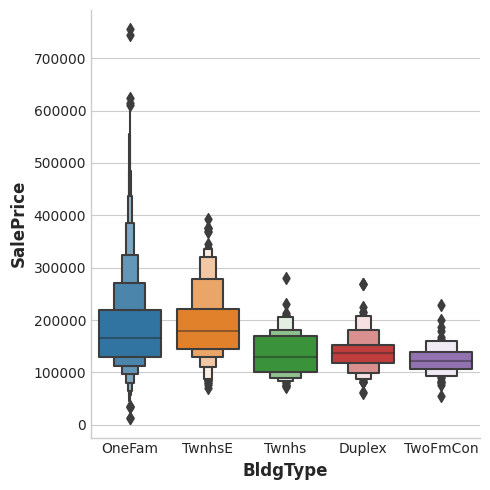

In [10]:
sns.catplot(x="BldgType", y="SalePrice", data=df, kind="boxen")

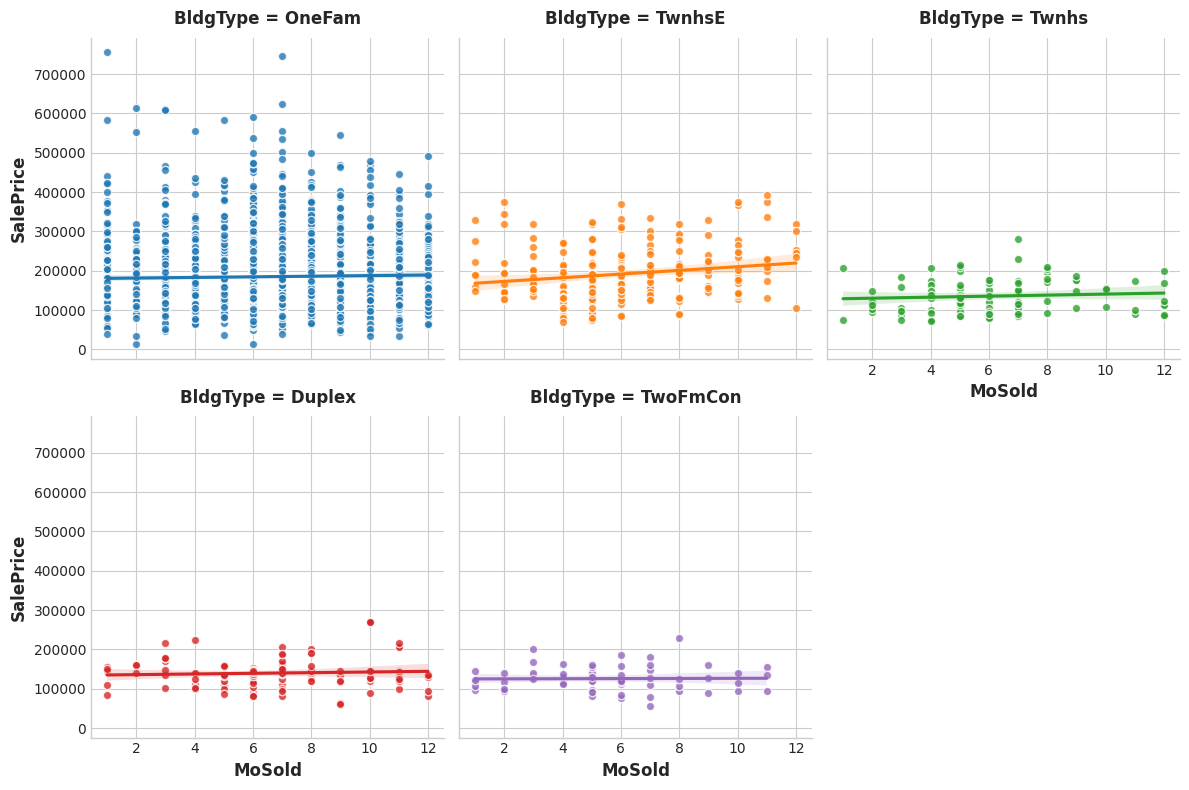

In [11]:
# YOUR CODE HERE: 
feature = "MoSold"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

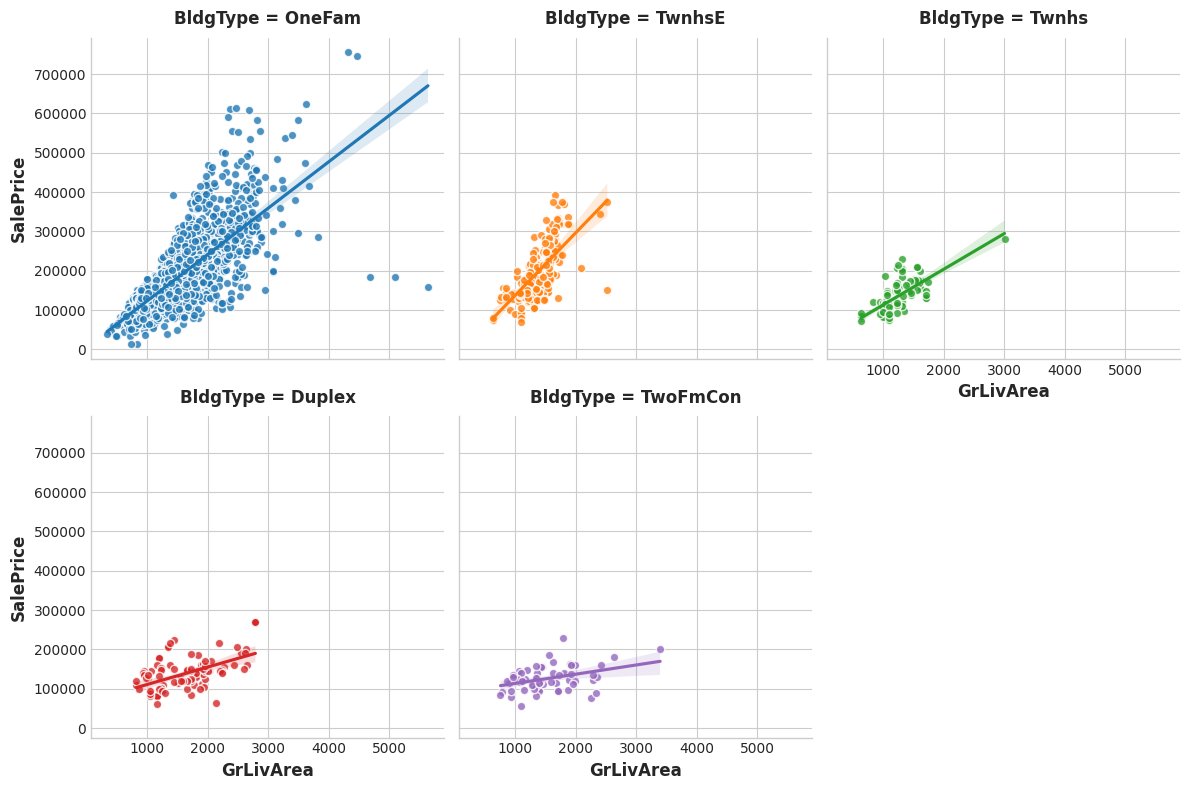

In [12]:
# YOUR CODE HERE: 
feature = "GrLivArea"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

### Analysis:
The trends lines within each category of BldgType are clearly very different, indicating an interaction between these features. Since knowing BldgType tells us more about how GrLivArea relates to SalePrice, we should consider including BldgType in our feature set.

The trend lines for MoSold, however, are almost all the same. This feature hasn't become more informative for knowing BldgType.

## Mathematical Transforms
Relationships among numerical features are often expressed through mathematical formulas, which you'll frequently come across as part of your domain research. In Pandas, you can apply arithmetic operations to columns just as if they were ordinary numbers.

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


# Prepare data
df = pd.read_csv("data_feature/ames.csv")
X = df.copy()
y = X.pop("SalePrice")

In [15]:
# Simple transformations: ratios, sums
X_1 = pd.DataFrame()  # dataframe to hold new features

X_1["LivLotRatio"] = X["GrLivArea"]/X["LotArea"]
X_1["Spaciousness"] = (X["FirstFlrSF"]+X["SecondFlrSF"])/X["TotRmsAbvGrd"]
X_1["TotalOutsideSF"] = X[["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", 
                            "Threeseasonporch", "ScreenPorch"]].sum(axis=1)

## Modelling numeric and categorical variables together
If you've discovered an interaction effect between a numeric feature and a categorical feature, you might want to model it explicitly using a one-hot encoding:

In [22]:
# One-hot encode BldgType. Use `prefix="Bldg"` in `get_dummies`
X_2 = pd.get_dummies(df.BldgType, prefix="Bldg")
print(X_2.head(10))
# Multiply
X_2 = X_2.mul(df.GrLivArea, axis=0)
print(df.GrLivArea.head(10))
X_2.head(10)

   Bldg_Duplex  Bldg_OneFam  Bldg_Twnhs  Bldg_TwnhsE  Bldg_TwoFmCon
0        False         True       False        False          False
1        False         True       False        False          False
2        False         True       False        False          False
3        False         True       False        False          False
4        False         True       False        False          False
5        False         True       False        False          False
6        False        False       False         True          False
7        False        False       False         True          False
8        False        False       False         True          False
9        False         True       False        False          False
0    1656.0
1     896.0
2    1329.0
3    2110.0
4    1629.0
5    1604.0
6    1338.0
7    1280.0
8    1616.0
9    1804.0
Name: GrLivArea, dtype: float64


,Bldg_Duplex,Bldg_OneFam,Bldg_Twnhs,Bldg_TwnhsE,Bldg_TwoFmCon
0,0.0,1656.0,0.0,0.0,0.0
1,0.0,896.0,0.0,0.0,0.0
2,0.0,1329.0,0.0,0.0,0.0
3,0.0,2110.0,0.0,0.0,0.0
4,0.0,1629.0,0.0,0.0,0.0
5,0.0,1604.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1338.0,0.0
7,0.0,0.0,0.0,1280.0,0.0
8,0.0,0.0,0.0,1616.0,0.0
9,0.0,1804.0,0.0,0.0,0.0


## Count Features
Features describing the presence or absence of something often come in sets, the set of risk factors for a disease, say. You can aggregate such features by creating a count.

In [28]:
X_3 = pd.DataFrame()

# YOUR CODE HERE
interested_cols = ["WoodDeckSF","OpenPorchSF","EnclosedPorch","Threeseasonporch",
"ScreenPorch"]
X_3["PorchTypes"] = X[interested_cols].gt(0).sum(axis=1)

X_3["PorchTypes"]
## Porch type is the count of cols in interested cols > 0 for each row.
## if axis = 0, counts no. of rows w values > 0 for each column

0       2
1       2
2       2
3       0
4       2
       ..
2925    1
2926    1
2927    2
2928    2
2929    2
Name: PorchTypes, Length: 2930, dtype: int64

## Building-Up and Breaking-Down Features
Often you'll have complex strings that can usefully be broken into simpler pieces.
You could also join simple features into a composed feature if you had reason to believe there was some interaction in the combination

In [32]:
X_4 = pd.DataFrame()
print(X["MSSubClass"].head())
# n = 1 splits only on first underscore _
X_4[["MSClass","rest"]] = X["MSSubClass"].str.split("_", n=1, expand=True)
# if only want one part
# X_4["MSClass"] = X["MSSubClass"].str.split("_", n=1, expand=True)[0]
print(X_4.head())

0    One_Story_1946_and_Newer_All_Styles
1    One_Story_1946_and_Newer_All_Styles
2    One_Story_1946_and_Newer_All_Styles
3    One_Story_1946_and_Newer_All_Styles
4               Two_Story_1946_and_Newer
Name: MSSubClass, dtype: object
  MSClass                             rest
0     One  Story_1946_and_Newer_All_Styles
1     One  Story_1946_and_Newer_All_Styles
2     One  Story_1946_and_Newer_All_Styles
3     One  Story_1946_and_Newer_All_Styles
4     Two             Story_1946_and_Newer


## Group Transforms
Finally we have Group transforms, which aggregate information across multiple rows grouped by some category. With a group transform you can create features like: "the average income of a person's state of residence," or "the proportion of movies released on a weekday, by genre." If you had discovered a category interaction, a group transform over that categry could be something good to investigate.

In [36]:
# Create a feature MedNhbdArea that describes the median of GrLivArea grouped on Neighborhood.
X_5 = pd.DataFrame()
X_5["MedNhbdArea"] = X.groupby("Neighborhood")["GrLivArea"].transform("median")
X_5[["Neighborhood","GrLivArea"]] = X[["Neighborhood","GrLivArea"]]
X_5.head(10)

# Another eg:
#customer["AverageIncome"] = (
#    customer.groupby("State")  # for each state
#    ["Income"]                 # select the income
#    .transform("mean")         # and compute its mean
#)

,MedNhbdArea,Neighborhood,GrLivArea
0,1200.0,North_Ames,1656.0
1,1200.0,North_Ames,896.0
2,1200.0,North_Ames,1329.0
3,1200.0,North_Ames,2110.0
4,1560.0,Gilbert,1629.0
5,1560.0,Gilbert,1604.0
6,1767.0,Stone_Brook,1338.0
7,1767.0,Stone_Brook,1280.0
8,1767.0,Stone_Brook,1616.0
9,1560.0,Gilbert,1804.0


## Using unsupervised learning algos: K-Means clustering
K-means clustering measures similarity using ordinary straight-line distance (Euclidean distance, in other words). It creates clusters by placing a number of points, called centroids, inside the feature-space. Each point in the dataset is assigned to the cluster of whichever centroid it's closest to. The "k" in "k-means" is how many centroids (that is, clusters) it creates. You define the k yourself.

You could imagine each centroid capturing points through a sequence of radiating circles. When sets of circles from competing centroids overlap they form a line. The result is what's called a Voronoi tessallation. The tessallation shows you to what clusters future data will be assigned; the tessallation is essentially what k-means learns from its training data.

K-means clustering creates a Voronoi tessallation of the feature space.
Let's review how the k-means algorithm learns the clusters and what that means for feature engineering. We'll focus on three parameters from scikit-learn's implementation: n_clusters, max_iter, and n_init.

It's a simple two-step process. The algorithm starts by randomly initializing some predefined number (n_clusters) of centroids. It then iterates over these two operations:

1) assign points to the nearest cluster centroid
2) move each centroid to minimize the distance to its points
It iterates over these two steps until the centroids aren't moving anymore, or until some maximum number of iterations has passed (max_iter).

It often happens that the initial random position of the centroids ends in a poor clustering. For this reason the algorithm repeats a number of times (n_init) and returns the clustering that has the least total distance between each point and its centroid, the optimal clustering.

### Since k-means clustering is sensitive to scale, it can be a good idea rescale or normalize data with extreme values. Our features are already roughly on the same scale, so we'll leave them as-is.

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

df = pd.read_csv("data_feature/housing.csv")
X = df.loc[:, ["MedInc", "Latitude", "Longitude"]]
X.head()

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


In [23]:
# Create cluster feature, n_init = no. of iterations of initialising and assigning to centroids
kmeans = KMeans(n_clusters=6, n_init=10, random_state=1)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head(10)

,MedInc,Latitude,Longitude,Cluster
0,8.3252,37.88,-122.23,3
1,8.3014,37.86,-122.22,3
2,7.2574,37.85,-122.24,3
3,5.6431,37.85,-122.25,3
4,3.8462,37.85,-122.25,0
5,4.0368,37.85,-122.25,0
6,3.6591,37.84,-122.25,0
7,3.1200,37.84,-122.25,0
8,2.0804,37.84,-122.26,0
9,3.6912,37.84,-122.25,0


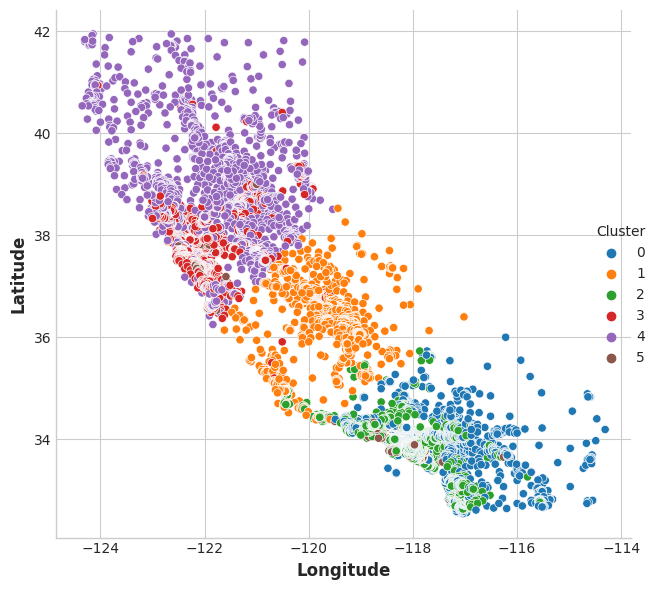

In [13]:
# Plots to visualise clustering
sns.relplot(
    x="Longitude", y="Latitude", hue="Cluster", data=X, height=6,
);

###  If the clustering is informative, these distributions should, for the most part, separate across MedHouseVal. Look at distributions with boxplots:

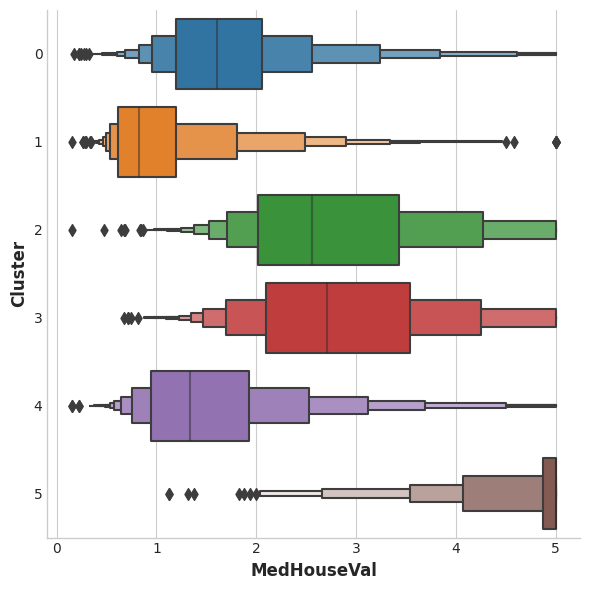

In [14]:
# Looking at boxplots of each cluster
X["MedHouseVal"] = df["MedHouseVal"]
sns.catplot(x="MedHouseVal", y="Cluster", data=X, kind="boxen", height=6);

In [26]:
kmeans = KMeans(n_clusters=6, n_init=10, random_state=1)
X_clusterdist = kmeans.fit_transform(X.drop("Cluster", axis=1))
X_clusterdist = pd.DataFrame(X_clusterdist)
X = X.join(X_clusterdist)

X.head(10)

,MedInc,Latitude,Longitude,Cluster,0,1,2,3,4,5
0,8.3252,37.88,-122.23,3,5.541723,6.459239,8.098116,2.839637,4.842606,6.434665
1,8.3014,37.86,-122.22,3,5.519206,6.429951,8.066635,2.813928,4.837814,6.404348
2,7.2574,37.85,-122.24,3,4.485306,6.058926,7.410970,1.781093,5.485203,5.514666
3,5.6431,37.85,-122.25,3,2.895840,5.812488,6.592650,0.344977,6.684324,4.272673
4,3.8462,37.85,-122.25,0,1.203510,6.046836,6.061241,1.686350,8.184661,3.286101
5,4.0368,37.85,-122.25,0,1.370453,5.996938,6.094731,1.499531,8.019739,3.359063
6,3.6591,37.84,-122.25,0,1.052368,6.094675,6.027367,1.869754,8.344219,3.218443
7,3.1200,37.84,-122.25,0,0.697994,6.280122,5.981036,2.403024,8.819296,3.095503
8,2.0804,37.84,-122.26,0,0.969301,6.752121,6.035697,3.437357,9.757226,3.126822
9,3.6912,37.84,-122.25,0,1.078308,6.084961,6.031635,1.838109,8.316177,3.228456


## When to rescale?
Features:

1) Latitude and Longitude of cities in California
2) Lot Area and Living Area of houses in Ames, Iowa
3) Number of Doors and Horsepower of a 1989 model car

Do we rescale?

1) No, since rescaling would distort the natural distances described by Latitude and Longitude.
2) Either choice could be reasonable, but because the living area of a home tends to be more valuable per square foot, it would make sense to rescale these features so that lot area isn't weighted in the clustering out of proportion to its effect on SalePrice, if that is what you were trying to predict.
3) Yes, since these don't have comparable units. Without rescaling, the number of doors in a car (usually 2 or 4) would have negligible weight compared to its horsepower (usually in the hundreds).

## PCA: Principle Component Analysis
Good explanation here: https://www.youtube.com/watch?v=FgakZw6K1QQ

There are two ways you could use PCA for feature engineering.

The first way is to use it as a descriptive technique. Since the components tell you about the variation, you could compute the MI scores for the components and see what kind of variation is most predictive of your target. That could give you ideas for kinds of features to create -- a product of 'Height' and 'Diameter' if 'Size' is important, say, or a ratio of 'Height' and 'Diameter' if Shape is important. You could even try clustering on one or more of the high-scoring components.

The second way is to use the components themselves as features. Because the components expose the variational structure of the data directly, they can often be more informative than the original features. Here are some use-cases:

- Dimensionality reduction: When your features are highly redundant (multicollinear, specifically), PCA will partition out the redundancy into one or more near-zero variance components, which you can then drop since they will contain little or no information.
- Anomaly detection: Unusual variation, not apparent from the original features, will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task.
- Noise reduction: A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.
- Decorrelation: Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.
PCA basically gives you direct access to the correlational structure of your data. 

#### PCA Best Practices
There are a few things to keep in mind when applying PCA:
1) PCA only works with numeric features, like continuous quantities or counts.
2) PCA is sensitive to scale. It's good practice to standardize your data before applying PCA, unless you know you have good reason not to.
3) Consider removing or constraining outliers, since they can have an undue influence on the results.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression

plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv("data_feature/autos.csv")

We've selected four features that cover a range of properties. Each of these features also has a high MI score with the target, price. We'll standardize the data since these features aren't naturally on the same scale.

In [3]:
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [7]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head(10)

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138
5,0.547265,-0.545141,0.139969,0.424955
6,0.869268,-0.472834,-0.294073,0.090174
7,0.974373,-0.449233,-0.435749,-0.019102
8,1.796553,-1.050783,-0.081821,-0.296071
9,-0.306514,-0.542020,0.138605,0.012612


### PCA Loadings (Weights)

In [8]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


The first component (PC1) shows a contrast between large, powerful vehicles with poor gas milage, and smaller, more economical vehicles with good gas milage.

The third component shows a contrast between horsepower and curb_weight -- sports cars vs. wagons, it seems.

#### We can look at rows of dataframe that contribute most to PC3:

In [9]:
# Show dataframe sorted by PC3
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body_style", "horsepower", "curb_weight"]
df.loc[idx, cols]

,make,body_style,horsepower,curb_weight
118,porsche,hardtop,207,2756
117,porsche,hardtop,207,2756
119,porsche,convertible,207,2800
45,jaguar,sedan,262,3950
96,nissan,hatchback,200,3139
...,...,...,...,...
59,mercedes-benz,wagon,123,3750
61,mercedes-benz,sedan,123,3770
101,peugot,wagon,95,3430
105,peugot,wagon,95,3485


### And then creating features from identifying patterns

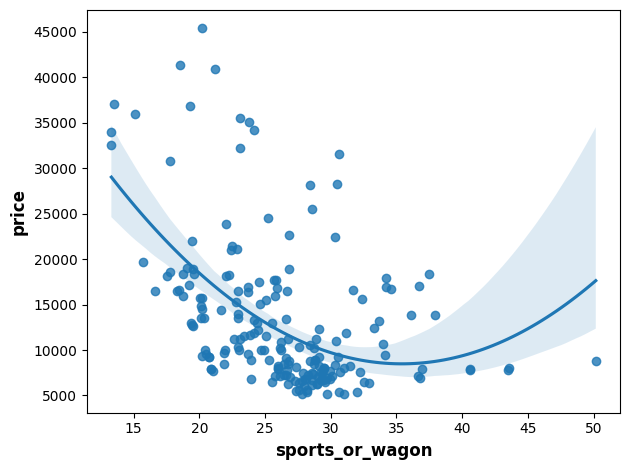

In [11]:
df["sports_or_wagon"] = X.curb_weight / X.horsepower
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2);

Useful functions from tutorial

In [13]:
from xgboost import XGBRegressor

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

pca, X_pca, loadings = apply_pca(X)
print(loadings)

                  PC1       PC2       PC3       PC4
highway_mpg -0.492347  0.770892  0.070142 -0.397996
engine_size  0.503859  0.626709  0.019960  0.594107
horsepower   0.500448  0.013788  0.731093 -0.463534
curb_weight  0.503262  0.113008 -0.678369 -0.523232


## Target Encoding
A target encoding is any kind of encoding that replaces a feature's categories with some number derived from the target.

In [1]:
# Simple eg: group aggregation (mean)
# computes the average price of each vehicle's make
import pandas as pd

autos = pd.read_csv("data_feature/autos.csv")
autos["make_encoded"] = autos.groupby("make")["price"].transform("mean")

autos[["make", "price", "make_encoded"]].head(10)

,make,price,make_encoded
0,alfa-romero,13495,15498.333333
1,alfa-romero,16500,15498.333333
2,alfa-romero,16500,15498.333333
3,audi,13950,17859.166667
4,audi,17450,17859.166667
5,audi,15250,17859.166667
6,audi,17710,17859.166667
7,audi,18920,17859.166667
8,audi,23875,17859.166667
9,bmw,16430,26118.750000


### Smoothing
An encoding like this presents a couple of problems, however. First are unknown categories. Target encodings create a special risk of overfitting, which means they need to be trained on an independent "encoding" split. When you join the encoding to future splits, Pandas will fill in missing values for any categories not present in the encoding split. These missing values you would have to impute somehow.

Second are rare categories. When a category only occurs a few times in the dataset, any statistics calculated on its group are unlikely to be very accurate. In the Automobiles dataset, the mercurcy make only occurs once. The "mean" price we calculated is just the price of that one vehicle, which might not be very representative of any Mercuries we might see in the future. Target encoding rare categories can make overfitting more likely.

A solution to these problems is to add smoothing. The idea is to blend the in-category average with the overall average. Rare categories get less weight on their category average, while missing categories just get the overall average.

In pseudocode:

`encoding = weight * in_category + (1 - weight) * overall`
where weight is a value between 0 and 1 calculated from the category frequency.

An easy way to determine the value for weight is to compute an m-estimate:

`weight = n / (n + m)`

where n is the total number of times that category occurs in the data. The parameter m determines the "smoothing factor". Larger values of m put more weight on the overall estimate.

### Example:
n the Automobiles dataset there are three cars with the make chevrolet. If you chose m=2.0, then the chevrolet category would be encoded with 60% of the average Chevrolet price plus 40% of the overall average price.

`chevrolet = 0.6 * 6000.00 + 0.4 * 13285.03`

#### Choosing m
When choosing a value for m, consider how noisy you expect the categories to be. Does the price of a vehicle vary a great deal within each make? Would you need a lot of data to get good estimates? If so, it could be better to choose a larger value for m; if the average price for each make were relatively stable, a smaller value could be okay.

#### When to use target encoding:
Use Cases for Target Encoding
Target encoding is great for:
High-cardinality features: A feature with a large number of categories can be troublesome to encode: a one-hot encoding would generate too many features and alternatives, like a label encoding, might not be appropriate for that feature. A target encoding derives numbers for the categories using the feature's most important property: its relationship with the target.
Domain-motivated features: From prior experience, you might suspect that a categorical feature should be important even if it scored poorly with a feature metric. A target encoding can help reveal a feature's true informativeness.

### Eg. With Ames Dataset

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


df = pd.read_csv("data_feature/ames.csv")

#### Identifying categorical variables with high no. of unique categories

In [8]:
df.select_dtypes(["object"]).nunique().sort_values(ascending=False)[0:5]

Neighborhood    28
Exterior2nd     17
MSSubClass      16
Exterior1st     16
SaleType        10
dtype: int64

#### Taking a look at Neighborhood, look at counts of categories
M-estimate encoding uses smoothing to improve estimates for rare categories. We see that the "Neighborhood" category has a couple of rare categories:

In [14]:
df["Neighborhood"].value_counts().tail(5)

Neighborhood
Northpark_Villa    23
Blueste            10
Greens              8
Green_Hills         2
Landmark            1
Name: count, dtype: int64

#### To avoid overfitting, we need to fit the encoder on data heldout from the training set.

In [15]:
# Encoding split
X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("SalePrice")

# Training split
X_pretrain = df.drop(X_encode.index)
y_train = X_pretrain.pop("SalePrice")

In [22]:
encoder = MEstimateEncoder(cols=["Neighborhood"], m=10.0)

# Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)
print(X_encode.Neighborhood.head(10))
print(X_train.Neighborhood.head(10))

2216                  Crawford
836              College_Creek
2396        Northridge_Heights
1962                North_Ames
305     Iowa_DOT_and_Rail_Road
1139               Sawyer_West
727     Iowa_DOT_and_Rail_Road
1663                North_Ames
2817                   Edwards
1511                   Edwards
Name: Neighborhood, dtype: object
0     147095.512261
1     147095.512261
2     147095.512261
3     147095.512261
4     189513.394372
5     189513.394372
6     263294.469283
7     263294.469283
8     263294.469283
11    189513.394372
Name: Neighborhood, dtype: float64


#### Visualising how the encoded feature compares to the target

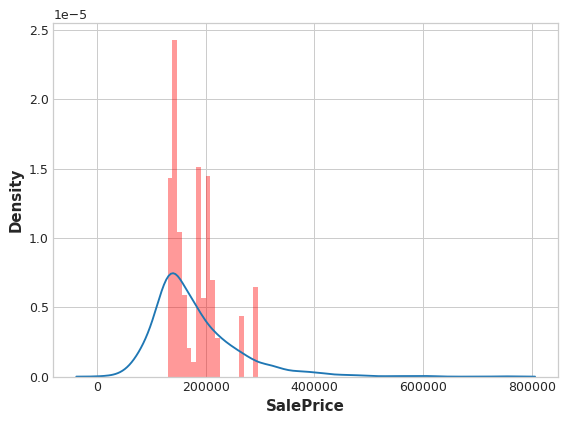

In [24]:
feature = encoder.cols

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=True, hist=False)
ax = sns.distplot(X_train[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

#### How encoded variables fare compared to original variables

In [25]:
X = df.copy()
y = X.pop("SalePrice")
score_base = score_dataset(X, y)
score_new = score_dataset(X_train, y_train)

print(f"Baseline Score: {score_base:.4f} RMSLE")
print(f"Score with Encoding: {score_new:.4f} RMSLE")

Baseline Score: 0.1431 RMSLE
Score with Encoding: 0.1386 RMSLE


#### What happens when we don't use a hold out set for target encoding:

In [26]:
# Try experimenting with the smoothing parameter m
# Try 0, 1, 5, 50
m = 1

X = df.copy()
y = X.pop('SalePrice')

# Create an uninformative feature
X["Count"] = range(len(X))
X["Count"][1] = 0  # actually need one duplicate value to circumvent error-checking in MEstimateEncoder

# fit and transform on the same dataset
encoder = MEstimateEncoder(cols="Count", m=m)
X = encoder.fit_transform(X, y)

# Results
score =  score_dataset(X, y)
print(f"Score: {score:.4f} RMSLE")

Score: 0.0294 RMSLE


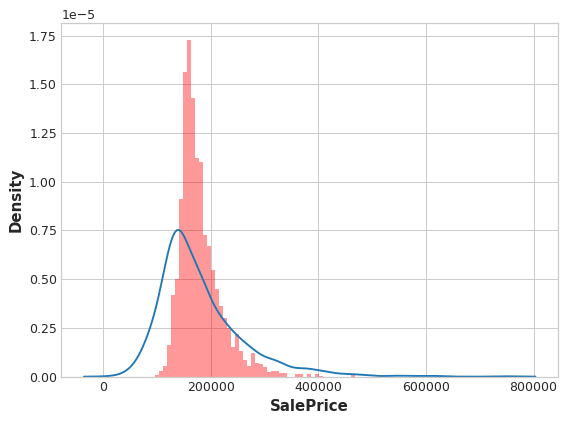

In [27]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=True, hist=False)
ax = sns.distplot(X["Count"], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

Since Count never has any duplicate values, the mean-encoded Count is essentially an exact copy of the target. In other words, mean-encoding turned a completely meaningless feature into a perfect feature.

Now, the only reason this worked is because we trained XGBoost on the same set we used to train the encoder. If we had used a hold-out set instead, none of this "fake" encoding would have transferred to the training data.

The lesson is that when using a target encoder it's very important to use separate data sets for training the encoder and training the model. Otherwise the results can be very disappointing!